<div style="text-align: center;">
 
# 🌟✨ **Exotic Option Pricing** ✨🌟
 
*This Jupyter notebook will help you plot and price exotic options*
 
*Author: Philip Bunford*
</div>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm
from colorama import Fore, Style
import sys
sys.path.append(r'/Users/philipbunford/Dropbox/UBP_Internship/UBP_Repo') #change this with the path where you hold the files below

# now imports from our files
from miscellaneous import simulate_gbm
from DownAndInPut import DownAndInPut, plot_hist_DownAndInPut, plot_DownAndInPut
from UpAndIn import UpAndInCall, plot_UpAndInCall
from UpAndOut import UpAndOut, UpAndOut_hist, UpAndOut_plot, UpAndOut_MC_plot # up_and_out_mtm_matrix
from Vanilla.blackscholesvanilla import black_scholes_call_value, black_scholes_put_value
from Vanilla.VanillaCall_Plotting import plot_call_payoff
from exotic_greeks import (call_vomma,put_vomma,call_vanna,put_vanna,call_charm,put_charm,call_zomma,put_zomma,call_color,put_color,call_speed,put_speed,call_ultima,put_ultima,plot_vomma_,plot_vanna_,plot_charm_,plot_zomma_,plot_color_,plot_speed_,plot_ultima_)
 
from Vanilla.vanilla_greeks import (phi, gamma, vega, call_delta, call_theta, call_rho, put_delta, put_theta, put_rho, plot_call_theta_, plot_gamma_, plot_call_rho_, plot_vega_, plot_call_delta_, plot_call_greeks_, plot_multiple_deltas, plot_all_greeks)
 

(10000, 253)



 
### Parameters we will use in our functions
 
- s_0: This is the initial stock price ($ S_0 $) or the price of the underlying asset at the start of the option's life.
- r:  This is the risk-free interest rate, expressed as a decimal (6% in this case).
    - Purpose: It represents the return on a risk-free investment, such as government bonds, and is used to discount future cash flows to their present value.
- sigma: This is the volatility of the underlying asset, expressed as a decimal (50% in this case).
    - Purpose: Volatility measures the degree of variation in the price of the underlying asset over time. Higher volatility means the price is more unpredictable.
- K: This is the strike price of the option.
    - Purpose: The strike price is the price at which the holder of the option can buy (for a call option) or sell (for a put option) the underlying asset.
- BARRIER: This is the barrier level for a barrier option.
    - Purpose: Barrier options are a type of exotic option where the payoff depends on whether the underlying asset's price reaches a certain level (the barrier) during the option's life.
        - Knock-In Option: Becomes active only if the price hits the barrier.
        - Knock-Out Option: Becomes void if the price hits the barrier.
- dt: This is the time step size in the simulation.
    - Purpose: It represents the length of each time interval in the simulation, in years.
- discount_factor: This is the discount factor used to calculate the present value of future cash flows.
    - Purpose: It adjusts the future payoff of the option to its present value, accounting for the time value of money.
- observation= 'daily': This specifies the frequency of observation for the option (you can modify this to 'european')
    - Purpose: Determines how often the underlying asset's price is observed for the purpose of calculating the option's payoff.
        - 'daily': The option is monitored daily (e.g., for barrier options, the barrier is checked every day).
        - 'european': The option is only evaluated at maturity (e.g., European options).

In [ ]:
# Here we define our initial parameters --------------------------------------------------
 
S_0 = 100
r = 0.0397
sigma = 0.5
div_yield = 0.1
K = 100  # Strike price
BARRIER = 80  # Barrier level
n_sims = 100_000
T = 1
N = 252
dt = T / N
discount_factor = np.exp(-r * T)
observation = 'daily' #european if you want european


 
### Geometric Brownian Motion (GBM)
 
This function simulates paths for the underlying asset price. GBM is a stochastic process commonly used in finance to model stock prices. The parameters are:
 
 
#### Components of the Function
 
##### Inputs:
- `s_0`: Initial stock price ($ S_0 $).
- `mu`: Drift or expected return of the stock ($ \mu $).
- `sigma`: Volatility of the stock ($ \sigma $).
- `dt`: Time step size ($ \Delta t $).
- `n_sims`: Number of simulations (number of price paths to generate).
- `random_seed`: Seed for the random number generator to ensure reproducibility.
 
##### Outputs:
- `S_t`: A 2D array where each row represents a simulated stock price path over time.
 
---
 
### How the function works:
 
1. Random Walk Generation:
- The random component of GBM is modeled using a standard normal distribution scaled by $ \sqrt{\Delta t} $, which ensures that the random increments are consistent with the properties of Brownian motion.
- $ dW $ represents the random changes in the stock price due to the stochastic component.
 
2. Stock Price Simulation:
- The stock price at each time step is calculated using the GBM formula:
 
$$
S_t = S_0 \cdot \exp\left( \sum_{t=1}^{N} \left( (\mu - d - 0.5 \cdot \sigma^2) \cdot \Delta t + \sigma \cdot dW \right) \right)
$$
 
Where:
- $ \mu - 0.5 \cdot \sigma^2 $: Adjusted drift term, accounting for the volatility drag.
- $ \sigma \cdot dW $: Random component driven by Brownian motion.
 
3. Initial Price Correction:
- The first column of the simulated paths is set to the initial stock price ($ S_0 $).

In [3]:
def simulate_gbm(s_0, mu, sigma, dt, n_sims, N, div_yield=0.0, random_seed=102):
    """
    Simulate stock returns using Geometric Brownian Motion with dividend yield.
    Parameters:
    - s_0: Initial stock price
    - mu: Risk-free rate
    - sigma: Volatility
    - dt: Time step
    - n_sims: Number of simulations
    - N: Number of time steps
    - div_yield: Dividend yield (default is 0.0)
    - random_seed: Seed for reproducibility (default is 102)
 
    Returns:
    - S_t: Simulated stock price paths (n_sims x (N + 1))
    """
    np.random.seed(random_seed)
 
    dW = np.random.normal(scale=np.sqrt(dt), size=(n_sims, N + 1))
 
    drift = (mu - div_yield - 0.5 * sigma**2) * dt
 
    S_t = s_0 * np.exp(np.cumsum(drift + sigma * dW, axis=1))
    S_t[:, 0] = s_0  # Set the initial stock price
 
    return S_t
 
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, dt=dt, n_sims=n_sims, N=N, div_yield=div_yield)
 
print(f"The shape of the GeomBM paths is: {gbm_sims.shape}")

The shape of the GeomBM paths is: (100000, 253)



### DownAndInPut Function
 
This function prices a **Down-and-In European Put Option** using Monte Carlo simulations. A Down-and-In Put is a type of barrier option that only becomes active if the underlying asset's price falls below a specified barrier level during the option's life.
 
---
 
#### Function Parameters
 
- **`gbm_sims`**: A 2D NumPy array of simulated stock price paths. Each row represents a single simulation, and each column represents a time step.
- **`K`**: Strike price of the put option.
- **`BARRIER`**: Barrier level. The option becomes active only if the stock price falls below this level.
- **`discount_factor`**: Discount factor to account for the time value of money (e.g., $ e^{-rT} $, where $ r $ is the risk-free rate and $ T $ is the time to maturity).
- **`observation`**: Determines when the barrier condition is checked:
  - `'european'`: The barrier is checked only at maturity (final time step).
  - `'daily'`: The barrier is checked at every time step.
 
---
 
#### Function:
 
#####  Barrier Condition Check
- If `observation` is `'european'`, the barrier condition is checked only at the final time step:
  ```python
  hit = gbm_sims[:, -1] < BARRIER

In [ ]:
S_0 = 100
r = 0.0397
sigma = 0.5
K = 100  # Strike price
BARRIER = 80  # Barrier level
n_sims = 100_000
T = 1
N = 252
dt = T / N
discount_factor = np.exp(-r * T)
observation = 'daily' #european if you want european

In [5]:
def DownAndInPut(gbm_sims, K, BARRIER, discount_factor, observation='european'):
    """
    Prices an Down-And-In European Put with Monte-Carlo.
    observation = 'european' → barrier checked only at maturity
    observation = 'daily' → barrier checked every day
    """
 
    if observation.lower() == 'european':
        hit = gbm_sims[:, -1] < BARRIER # final prices min
    else: # 'daily'
        hit = gbm_sims.min(axis=1) < BARRIER # path-wise min
 
    payoff = np.where(
        hit, #value if true (checks each row to calculate the payoff with the last value(price) )
                                            # takes all rows (every simulated path) and -1 takes the last column (i.e. the value at the final time-step T)
        np.maximum(0, K - gbm_sims[:, -1]),
        0)
 
    if BARRIER > K:
        print("You should input a Barrier < K")
 
    premium = discount_factor * payoff.mean()
    print(f"Price of the Down and In Put: {premium:.4f}")
 
    hit = (gbm_sims.max(axis=1) >= BARRIER)
    hit_rate = hit.mean()
    print(f"{Fore.RED}Hit rate from MC simulation: {hit_rate * 100:.2f}%{Style.RESET_ALL}")
 
    return premium
 
# use the function:
DownAndInPut(gbm_sims=gbm_sims, K=K, BARRIER=BARRIER, discount_factor=discount_factor)
 
 

Price of the Down and In Put: 18.5370
Hit rate from MC simulation: 100.00%


np.float64(18.537018662892443)

#### Plotting function for a DownAndIn put


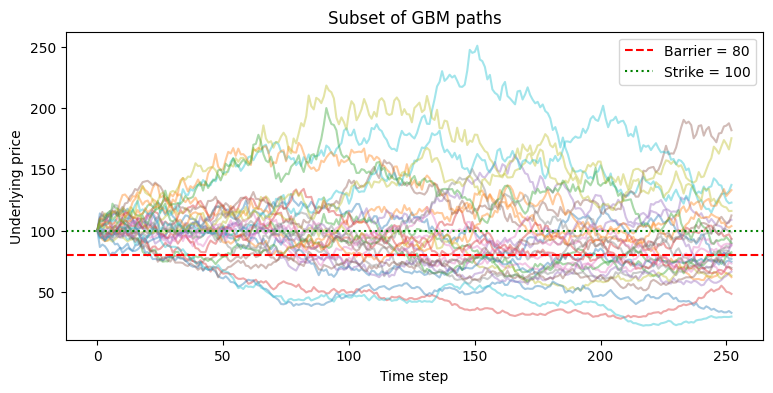

In [6]:
# Sample of simulated paths + barrier / strike ----------------------------------------------
def plot_MC_DownAndInPut(n_sims, gbm_sims, BARRIER, K):
    plt.figure(figsize=(9,4))
    sample = np.random.choice(n_sims, size=min(30, n_sims), replace=False)
 
    for idx in sample:
        plt.plot(gbm_sims[idx], alpha=0.4)
    plt.axhline(BARRIER, color='red', ls='--', label=f'Barrier = {BARRIER}')
    plt.axhline(K, color='green', ls=':', label=f'Strike = {K}')
    plt.title('Subset of GBM paths')
    plt.xlabel('Time step')
    plt.ylabel('Underlying price')
    plt.legend()
 
plot_MC_DownAndInPut(n_sims=n_sims, gbm_sims=gbm_sims, BARRIER=BARRIER, K=K)

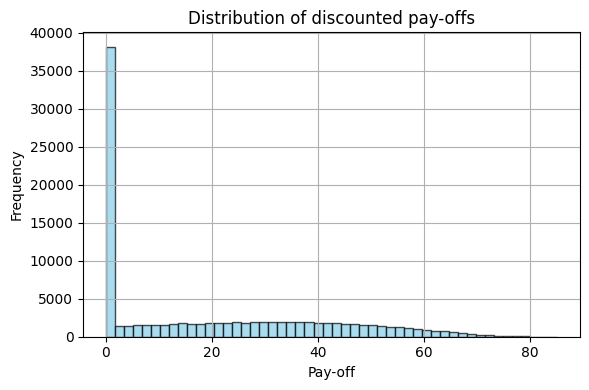

In [7]:
# Histogram of Monte-Carlo pay-offs (discounted) -----------------------------------------------
def plot_hist_DownAndInPut():        
    hit = gbm_sims.max(axis=1) > BARRIER
    payoffs = np.where(
        hit,
        np.maximum(0, K- gbm_sims[:,-1]),
        0)
 
    disc_pay = discount_factor * payoffs
 
    plt.figure(figsize=(6,4))
    plt.hist(disc_pay, bins=50, edgecolor='k', color='skyblue', alpha=0.7)
    plt.title('Distribution of discounted pay-offs')
    plt.xlabel('Pay-off')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.grid(True)
 
   
plot_hist_DownAndInPut()
 

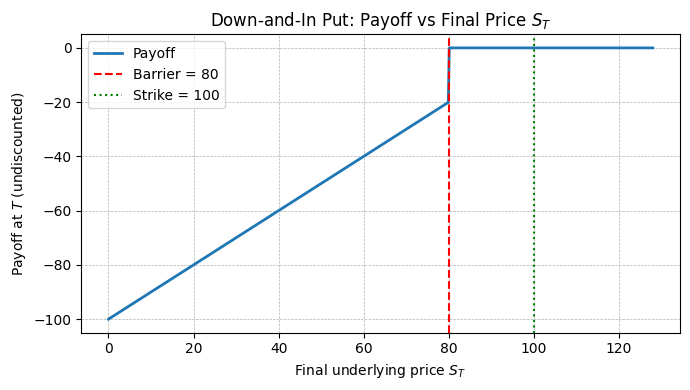

In [8]:
# Static payoff profile (undiscounted)----------------------------------------------------------------
def plot_DownAndInPut():
    x = np.linspace(0, BARRIER * 1.6, 600)  # Grid of S_T values
 
    # Short put payoff graph is min(S_t - X, 0)
    # Payoff logic for a down-and-in put
    payoff_profile = np.where(x <= BARRIER,  # If the barrier is breached
                            np.minimum(x - K, 0),  # Payoff is max(K - S_T, 0)
                            0)  # Otherwise, payoff is 0
 
    # Plotting the payoff profile
    plt.figure(figsize=(7, 4))
    plt.plot(x, payoff_profile, lw=2, label='Payoff')
    plt.axvline(BARRIER, color='red', ls='--', label=f'Barrier = {BARRIER}')
    plt.axvline(K, color='green', ls=':', label=f'Strike = {K}')
    plt.title('Down-and-In Put: Payoff vs Final Price $S_T$')
    plt.xlabel(r'Final underlying price $S_T$')
    plt.ylabel('Payoff at $T$ (undiscounted)')
    plt.legend()
    plt.grid(True, ls='--', lw=0.5)
    plt.tight_layout()
    plt.show()
 
plot_DownAndInPut()


 
### NB: I won't repeat the MC Sim, Histogram and Distribution of payoffs as they are mostly the same for all functions; i am here to concentrate on the functions
### Up And Out Call
 
 

In [ ]:
observation = 'daily'
option_type = 'call'
print(f"The shape of the GeomBM paths is: {gbm_sims.shape}")
 
S_0 = 55
r = 0.0397
sigma = 0.2
T = 1
N = 252
BARRIER = 80
K = 60
n_sims = 10000
dt = T / N
discount_factor = np.exp(-r * T) 

The shape of the GeomBM paths is: (100000, 253)



 
### Function intuition
 
1. **Purpose**  
   Prices an **up-and-out European option** (call **or** put) using Monte-Carlo-simulated price paths (`gbm_sims`).  
   If the underlying price ever rises to or above the barrier, the option is knocked out and its payoff becomes zero.
 
2. **Key inputs**
 
   | Argument | Meaning |
   |----------|---------|
   | `gbm_sims` | 2-D NumPy array shaped *(n_paths × n_timesteps)* of simulated underlying prices |
   | `K` | Strike price |
   | `BARRIER` | Up-and-out barrier level |
   | `discount_factor` | Present-value factor, e.g. \(e^{-rT}\) |
   | `observation` | `"european"` → barrier checked **only at maturity**<br>`"daily"` → barrier checked **every time step** |
   | `option_type` | `"call"` or `"put"` |
 
3. **Barrier test (`hit`)**
 
   ```python
   if observation.lower() == "european":
       hit = gbm_sims[:, -1] >= BARRIER          # final price only
   else:  # "daily"
       hit = gbm_sims.max(axis=1) >= BARRIER     # path-wise max
   ```
   hit is a Boolean vector showing which paths touch or cross the barrier.
 
4. **Payoff per path**
 
   If the **barrier was hit**, the payoff is:
 
   $$
   \text{Payoff} = 0
   $$
 
   Otherwise:
 
   For a **Call Option**, the payoff is:
 
   $$
   \text{Payoff} = \max(S_T - K, 0)
   $$
 
   For a **Put Option**, the payoff is:
 
   $$
   \text{Payoff} = \max(K - S_T, 0)
   $$
 
   In Python, this can be implemented as:
 
   ```python
   # For a Call Option
   payoff = np.where(hit, 0, np.maximum(0, gbm_sims[:, -1] - K))
 
   # For a Put Option
   payoff = np.where(hit, 0, np.maximum(0, K - gbm_sims[:, -1]))
 
5. **Premium computation**
   python
   CopyEdit
   premium = discount_factor * payoff.mean()
   Average the non-knocked-out payoffs across all paths and discount them back to today.
6. **Diagnostics printed**
   - Option price: premium
   - Hit rate: hit.mean() — percentage of paths that reached the barrier
7. **Return value**
Returns premium so the price can be reused programmatically.
 
 

In [10]:
def UpAndOut(gbm_sims, K, BARRIER, discount_factor, observation='european', option_type='call'):
    """
   
    Prices an up-and-out European call or put.
    observation = 'european' → barrier checked only at maturity
    observation = 'daily' → barrier checked every day
 
    """
 
    # European or Daily observation
 
    if observation.lower() == 'european':
        hit = gbm_sims[:, -1] >= BARRIER # final prices only
    else: # 'daily'
        hit = gbm_sims.max(axis=1) >= BARRIER # path-wise max
 
    # Option or call
    if option_type.lower() == 'call':
        payoff = np.where(hit, 0, np.maximum(0, gbm_sims[:, -1] - K))
    else:
        payoff = np.where(hit, 0, np.maximum(0, K - gbm_sims[:, -1]))
   
    premium = discount_factor * payoff.mean()
    print(f"{Fore.RED}Price of the up-and-in {option_type}: {premium:.4f}{Style.RESET_ALL}")
 
    hit_rate = hit.mean()
    print(f"{Fore.RED}Hit rate from MC simulation: {hit_rate * 100:.2f}%{Style.RESET_ALL}")
 
    return premium
 
UpAndOut(
        gbm_sims=gbm_sims,
        K=K,
        BARRIER=BARRIER,
        discount_factor=discount_factor,
        observation=observation,
        option_type=option_type
    )
 

Price of the up-and-in call: 0.0000
Hit rate from MC simulation: 100.00%


np.float64(0.0)

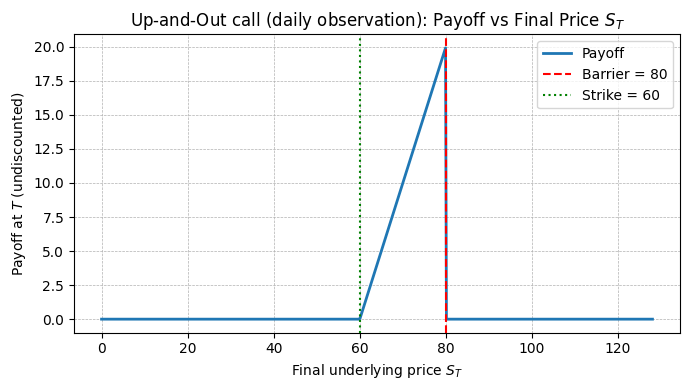

In [11]:
# Static payoff profile (undiscounted) ---------------------------------
 
def UpAndOut_plot(option_type):
 
    x = np.linspace(0, BARRIER * 1.6, 600) # grid of S_T values (barrier x 1.6 ensures the whole price path is as least as big as 1.6 times the barrier)
 
    if option_type.lower() == 'call':
        payoff_profile = np.where(x >= BARRIER, 0, np.maximum(0, x - K))
    else: # 'put'
        payoff_profile = np.where(x <= BARRIER, 0, np.maximum(0, K - x))
 
    plt.figure(figsize=(7, 4))
    plt.plot(x, payoff_profile, lw=2, label='Payoff')
    plt.axvline(BARRIER, color='red', ls='--', label=f'Barrier = {BARRIER}')
    plt.axvline(K, color='green', ls=':', label=f'Strike = {K}')
    plt.title(f"Up-and-Out {option_type} ({observation} observation): Payoff vs Final Price $S_T$")
    plt.xlabel(r'Final underlying price $S_T$')
    plt.ylabel('Payoff at $T$ (undiscounted)')
    plt.legend()
    plt.grid(True, ls='--', lw=0.5)
    plt.tight_layout()
    plt.show()
 
UpAndOut_plot(option_type=option_type)
 


### Up And Out Mark-to-Market Matrix creation
 
 
 

In [12]:
def up_and_out_mtm_matrix(
    S_0,
    price_factors=(0.90, 1.00, 1.10),       # 90 %, 100 %, 110 %
    tenors=(0.5, 1.0, 2.5),                 # in years
    r=0.06,
    sigma=0.2,
    K=60,
    BARRIER=80,
    n_sims=10_000,
    N_per_year=252,
    option_type="call",
    observation="daily",
    excel_file=r"M:\PB\Python_projects\UBP_Repo\up_and_out_mtm_matrix.xlsx"  # obviously here put in your own path!
    ):
 
    """
    Builds a price matrix (rows = spot factors, columns = tenors) and
    saves it to `excel_file`.
    """
    # Prepare empty DataFrame
    df = pd.DataFrame(
        index=[f"{int(pf*100)}%" for pf in price_factors],
        columns=tenors,
        dtype=float,
    )
 
    # Loop over all tenor / spot-factor combinations
    for T in tenors:
        N = int(N_per_year * T)         # time steps ∝ tenor
        dt = T / N
        discount = np.exp(-r * T)
 
        for pf in price_factors:
            S_start = S_0 * pf  # create the price as a percentage
 
            # fresh GBM paths for this scenario
            sims = simulate_gbm(s_0=S_start, mu=r, sigma=sigma, dt=dt, n_sims=n_sims, N=N, div_yield=div_yield)

                

 
            price = UpAndOut(
                gbm_sims=sims,
                K=K,
                BARRIER=BARRIER,
                discount_factor=discount,
                observation=observation,
                option_type=option_type,
            )
 
            df.loc[f"{int(pf*100)}%", T] = price
 
    # Save & echo
    df.to_excel(excel_file, float_format="%.6f")  # Save as Excel file
    print(f"\nPrice matrix written to '{excel_file}':\n")
    print(df)
 
    return df
 
if __name__ == "__main__":
 
    up_and_out_mtm_matrix(
        S_0,
        price_factors=(0.90, 1.00, 1.10),       # 90 %, 100 %, 110 %
        tenors=(0.5, 1.0, 2.5),                 # in years
        r=0.06,
        sigma=0.2,
        K=60,
        BARRIER=80,
        n_sims=10_000,
        N_per_year=252,
        option_type="call",
        observation="daily",
        excel_file="up_and_out_mtm_matrix.xlsx",
    )

Price of the up-and-in call: 0.2142
Hit rate from MC simulation: 0.03%
Price of the up-and-in call: 0.9207
Hit rate from MC simulation: 0.42%
Price of the up-and-in call: 2.3223
Hit rate from MC simulation: 2.91%
Price of the up-and-in call: 0.4834
Hit rate from MC simulation: 0.63%
Price of the up-and-in call: 1.1112
Hit rate from MC simulation: 2.91%
Price of the up-and-in call: 1.7784
Hit rate from MC simulation: 9.56%
Price of the up-and-in call: 0.4322
Hit rate from MC simulation: 5.83%
Price of the up-and-in call: 0.6409
Hit rate from MC simulation: 12.04%
Price of the up-and-in call: 0.7520
Hit rate from MC simulation: 22.49%

Price matrix written to 'up_and_out_mtm_matrix.xlsx':

           0.5       1.0       2.5
90%   0.214202  0.483365  0.432224
100%  0.920731  1.111156  0.640933
110%  2.322255  1.778421  0.752005



 
### Up And In Call
 

In [ ]:

S_0 = 55 * 1.10
r = 0.0397
sigma = 0.2
T = 1 * 0.5
N = 252 * T
 
BARRIER = 65
K = 60
n_sims = 1000
 
observation = 'european' #change to daily if daily
 
dt = T / N
discount_factor = np.exp(-r * T)
 
 


 
 
The `UpAndInCall` function is designed to price an **up-and-in European call option** using Monte Carlo simulations. An up-and-in call is a type of barrier option that only becomes active (or "knocks in") if the underlying asset's price reaches or exceeds a specified **barrier level** during the option's life.
 
#### Function Parameters:
- **`gbm_sims`**: A 2D array of simulated price paths for the underlying asset (rows represent paths, columns represent time steps).
- **`K`**: The strike price of the option.
- **`BARRIER`**: The barrier level that must be breached for the option to become active.
- **`discount_factor`**: The discount factor to account for the time value of money.
- **`observation`**: Determines when the barrier is checked:
  - `'european'`: Barrier is checked only at maturity.
  - `'daily'`: Barrier is checked at every time step.
 
#### Function Logic:
1. **Barrier Check**:
   - If `observation='european'`, the barrier is checked only at the final time step (`gbm_sims[:, -1]`).
   - If `observation='daily'`, the barrier is checked across the entire path (`gbm_sims.max(axis=1)`).
 
2. **Payoff Calculation**:
   - If the barrier is breached (`hit=True`), the payoff is the maximum of $ S_T - K $ or 0, where $ S_T $ is the final price of the underlying asset.
   - If the barrier is not breached, the payoff is 0.
 
3. **Premium Calculation**:
   - The option premium is calculated as the discounted average of all payoffs.
 
4. **Hit Rate**:
   - The function also calculates the proportion of paths where the barrier was breached (hit rate).
 
#### Outputs:
- Prints the calculated **option premium** and the **hit rate** from the Monte Carlo simulation.
- Returns the option premium.

In [14]:
def UpAndInCall(gbm_sims, K, BARRIER, discount_factor, observation='european'):
    """
   
    Prices an up-and-in European call.
    observation = 'european' → barrier checked only at maturity
    observation = 'daily' → barrier checked every day
 
    """
    if observation.lower() == 'european':
        hit = gbm_sims[:, -1] >= BARRIER # final prices only
    else: # 'daily'
        hit = gbm_sims.max(axis=1) >= BARRIER # path-wise max
 
    # Payoff: (payoff function explained: if the hit condition is met, i.e. that the last MC path is >= to the BARRIER,
    # the payoff is the max between the last price - K or 0. In addition, if the condition is not met, then the output is also 0)
 
    payoff = np.where(
        hit, # final price of the MC paths that are subject to a >= barrier logic
        np.maximum(0, gbm_sims[:, -1] - K), # array will be created based
        0
    )
 
    premium = discount_factor * payoff.mean()
    print(f"{Fore.RED}Price of the up-and-in Call: {premium:.4f}{Style.RESET_ALL}")
 
    hit = (gbm_sims.max(axis=1) >= BARRIER)
    hit_rate = hit.mean()
    print(f"{Fore.RED}Hit rate from MC simulation: {hit_rate * 100:.2f}%{Style.RESET_ALL}")
 
    return premium
 
# Example usage
UpAndInCall(gbm_sims=gbm_sims, K=K, BARRIER=BARRIER, discount_factor=discount_factor, observation=observation)
 

Price of the up-and-in Call: 38.0296
Hit rate from MC simulation: 100.00%


np.float64(38.02960285170858)

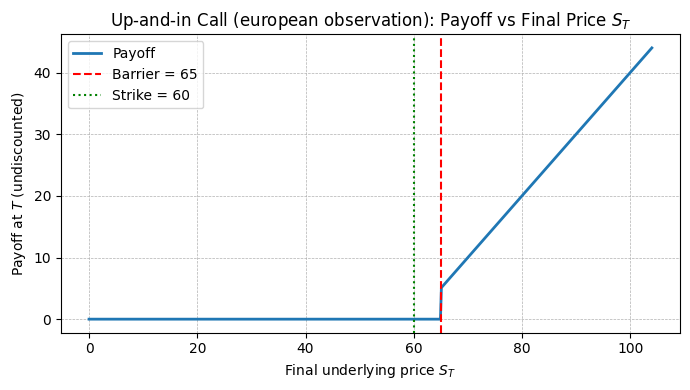

In [15]:
# Static payoff profile (undiscounted) ------------------------------------------------------
 
def plot_UpAndInCall():
    x = np.linspace(0, BARRIER * 1.6, 600) # grid of S_T values (barrier x 1.6 ensures the whole price path is as least as big as 1.6 times the barrier)
 
    payoff_profile = np.where(x >= BARRIER,
    np.maximum(0, x - K),
    0)
 
    plt.figure(figsize=(7, 4))
    plt.plot(x, payoff_profile, lw=2, label='Payoff')
    plt.axvline(BARRIER, color='red', ls='--', label=f'Barrier = {BARRIER}')
    plt.axvline(K, color='green', ls=':', label=f'Strike = {K}')
    plt.title(f"Up-and-in Call ({observation} observation): Payoff vs Final Price $S_T$")
    plt.xlabel(r'Final underlying price $S_T$')
    plt.ylabel('Payoff at $T$ (undiscounted)')
    plt.legend()
    plt.grid(True, ls='--', lw=0.5)
    plt.tight_layout()
    plt.show()
 
plot_UpAndInCall()
 


### Bull Spread

In [ ]:
# Here we define our initial parameters ------------------------------------------------------------- init parameters
 
n_sims = 100_000
N = 252
S = 32.21
K = 32.21
r = 0.0397
T = 1
 
maturities = [0.5,1,2]
 
# strikes
long_call_strike = 1.00  # ATM
short_call_strike = 1.20  # 20 % OTM
short_put_strike = 1.00  # ATM
long_put_strike = 0.98  # 2 % OTM
 
# vol
ATM_vol = 0.295
short_call_vol = 0.33
long_put_vol = 0.292
 
vol = 0.33
 
greek_you_want = 'delta'
 

In [17]:
# N.B. Here, you choose the underlying price scenario yourself - this can be done with a Monte-carlo simulation if wanted, and you could extract 3 random prices if you wanted to, for example.  
 
demo_params = {
    "K": 100.0,
    "scenarios": [
        {"S": 120, "sigma": 0.33, "r": 0.04, "T": 0.5},
        {"S": 150, "sigma": 0.45, "r": 0.04, "T": 1.0},
        {"S": 130, "sigma": 0.40, "r": 0.04, "T": 1.5},
    ],
}
 
 


 
 
 
### 🐂 **Bull Spread Pricing Function** 🐂
 
This file defines the **Bull Spread Pricing** function and demonstrates how to calculate the premium for a bull spread strategy using the **Black-Scholes model**. Below is a detailed explanation of the code and its components.
 
---
 
#### 📌 **Initial Parameters**
 
The following parameters are defined at the beginning of the script:
 
Bull Spread Premium Calculation
The total premium for the bull spread is calculated as:
 
```
BullSpread_Price = long_call - short_call - short_put + long_put
 

In [18]:
# BullSpread ----------------------------------------------------------------------------------- Bullspread price + plot
 
def BullSpread_Price(
                    S, #initial price
                    K,  #strike will always equal spot price * a parameter  
                    r,
                    T,
                    show=True):
 
    '''
    Parameters:
    long_call_strike = if atm, then input = 1
    short_call_strike = if otm (e.g. 120%) input 1.2
    short_put_strike = if atm then input = 1
    long_put_strike = if otm then (e.g. 80%), then input = 0.8
    '''
 
    # calculate option values
    long_call = black_scholes_call_value(S, K * long_call_strike, r, T, ATM_vol)
    short_call = black_scholes_call_value(S, K * short_call_strike, r, T, short_call_vol)
    short_put = black_scholes_put_value(S, K * short_put_strike, r, T, ATM_vol)
    long_put = black_scholes_put_value(S, K * long_put_strike, r, T, long_put_vol)
 
    BullSpread_Price = long_call - short_call - short_put + long_put # total value of the BullSpread Price
   
    return BullSpread_Price





BullSpreadPrice = BullSpread_Price(
                                S=S,
                                K=K,  
                                r=r,
                                T=T,
                                show=False
                                )
 
# printing it noicely:
text = f"BullSpread Premium: {BullSpreadPrice:.2f}"
box_width = len(text) + 2
print(
    f"╔{'═' * box_width}╗\n"
    f"║ {text.center(box_width - 2)} ║\n"
    f"╚{'═' * box_width}╝"
)
 
BullSpread_Price
 
 

╔══════════════════════════╗
║ BullSpread Premium: 0.12 ║
╚══════════════════════════╝


<function __main__.BullSpread_Price(S, K, r, T, show=True)>

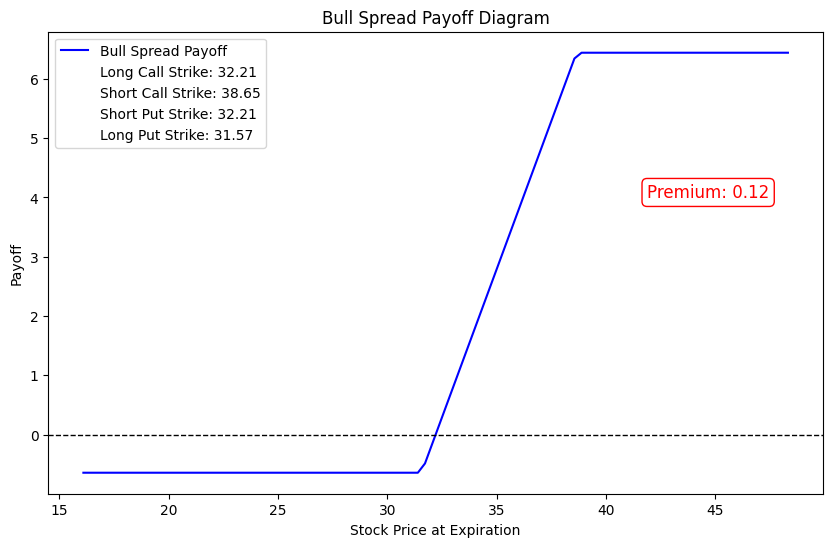

In [19]:
# call the function again:
bull_spread_premium  = BullSpread_Price(
                                S=S,
                                K=K,  
                                r=r,
                                T=T,
                                show=False
                                )
 
def plot_BullSpread(
                    S, #initial price
                    K,  #strike will always equal spot price * a parameter  
                    r,
                    T,
                    show=True
                    ):
                                                                           
                                                                                                           
        # Plotting:
 
        # Define payoff functions
        call_payoff = lambda S, K: np.maximum(S - K, 0.0)
        put_payoff = lambda S, K: np.maximum(K - S, 0.0)
 
        # Generate a range of stock prices at expiration
        S_range = np.linspace(S * 0.5, S * 1.5, 100)
 
        # Calculate final day payoffs for each leg of the strategy
        long_call_payoff = call_payoff(S_range, K * long_call_strike)
        short_call_payoff = -call_payoff(S_range, K * short_call_strike)
        short_put_payoff = -put_payoff(S_range, K * short_put_strike)
        long_put_payoff = put_payoff(S_range, K * long_put_strike)
 
        # Total payoff of the bull spread
        total_payoff = long_call_payoff + short_call_payoff + short_put_payoff + long_put_payoff
 
        # Plot the payoff diagram
        plt.figure(figsize=(10, 6))
        plt.plot(S_range, total_payoff, label='Bull Spread Payoff', color='blue')
        plt.axhline(0, color='black', linestyle='--', linewidth=1)
 
        # Add strike levels to the legend
        plt.plot([], [], ' ', label=f'Long Call Strike: {K * long_call_strike:.2f}')
        plt.plot([], [], ' ', label=f'Short Call Strike: {K * short_call_strike:.2f}')
        plt.plot([], [], ' ', label=f'Short Put Strike: {K * short_put_strike:.2f}')
        plt.plot([], [], ' ', label=f'Long Put Strike: {K * long_put_strike:.2f}')
       
 
        # REMOVE IF YOU DON'T WANT TO SEE THE PREMIUM ON THE GRAPH:
 
        plt.text(S * 1.3, 4, f'Premium: {bull_spread_premium :.2f}', fontsize=12, color='red',
                bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))
 
        plt.title('Bull Spread Payoff Diagram')
        plt.xlabel('Stock Price at Expiration')
        plt.ylabel('Payoff')
        plt.legend()
 
        if show:
            plt.show()


plot_BullSpread(
                S=S, #initial price
                K=K,  #strike will always equal spot price * a parameter  
                r=r,
                T=T,
                show=True
                )


 
Here we create a function dictionary referencing each call or put function for each respective greek (which is defined in another file)
 
- this will allow us to dynamically plot any pricing scenario (3 specifically) for the greek we choose
 
 
 
 
 
 
 

In [20]:

function_dictionary = {
    "delta": {"call": "call_delta", "put": "put_delta"},
    "gamma": {"call": "gamma", "put": "gamma"},             # Gamma is the same for both calls and puts
    "vega": {"call": "vega", "put": "vega"},                # Vega is the same for both calls and puts
    "theta": {"call": "call_theta", "put": "put_theta"},
    "rho": {"call": "call_rho", "put": "put_rho"},
    "vomma": {"call": "call_vomma", "put": "put_vomma"},   # Vomma (volga) measures sensitivity to volatility
    "vanna": {"call": "call_vanna", "put": "put_vanna"},   # Vanna measures sensitivity to changes in volatility and spot price
    "charm": {"call": "call_charm", "put": "put_charm"},   # Charm measures the rate of change of delta over time
    "zomma": {"call": "call_zomma", "put": "put_zomma"},   # Zomma measures the rate of change of gamma with respect to spot price
    "color": {"call": "call_color", "put": "put_color"},   # Color measures the rate of change of gamma over time
    "speed": {"call": "call_speed", "put": "put_speed"},   # Speed measures the rate of change of gamma with respect to spot price
    "ultima": {"call": "call_ultima", "put": "put_ultima"} # Ultima measures the sensitivity of vomma to changes in volatility
}
 
# here the user will be able to dynamically change the greek depending on what he wants. the greek will be then dynamically searched in a dictionary and spit out the corresponding bull spread greek
 
def bull_spread_greek(S, K, r, T, greek_you_want):
    """
    Vectorised—S can be scalar or array.
    The function dynamically selects the appropriate Greek calculation based on user input.
    """
    # Get the function references for the specified Greek
    call_function = globals()[function_dictionary[greek_you_want]["call"]] # globals will dynamically rerieve actual function objects (if not you return a string)
    put_function = globals()[function_dictionary[greek_you_want]["put"]]
   
    # Call the functions directly
    long_call = call_function(S, K * long_call_strike, r, T, ATM_vol)
    short_call = -call_function(S, K * short_call_strike, r, T, short_call_vol)
    short_put = -put_function(S, K * short_put_strike, r, T, ATM_vol)
    long_put = put_function(S, K * long_put_strike, r, T, long_put_vol)
   
    return long_call + short_call + short_put + long_put
 
greek = bull_spread_greek(
                S=S,
                K=K,
                r=r,
                T=T,
                greek_you_want=greek_you_want
                )
                   
text_2 = f"BullSpread Delta: {greek:.2f}"
box_width = len(text_2) + 2
print(
    f"╔{'═' * box_width}╗\n"
    f"║ {text_2.center(box_width - 2)} ║\n"
    f"╚{'═' * box_width}╝"
 
   
)

╔════════════════════════╗
║ BullSpread Delta: 0.00 ║
╚════════════════════════╝



 
 
 
 
 
 
 
This main function helps us plot the 3 scenarios that we define as params; this plots each greek with respect to price, for different tenures
 
Therefore, the function lets you pick 3 maturities (T) and instantly draws the chosen greek against spot for those horizons. YOu see three curves, each representing the desk's exposure at that future point in time.
 
now, if a client asks: if the underlying is 120 in six months, what's my delta?
 
 
 


=== Bull-Spread Prices ===
Scenario 1: T=0.50y Price = 11.3003
Scenario 2: T=1.00y Price = 14.8272
Scenario 3: T=1.50y Price = 10.2306


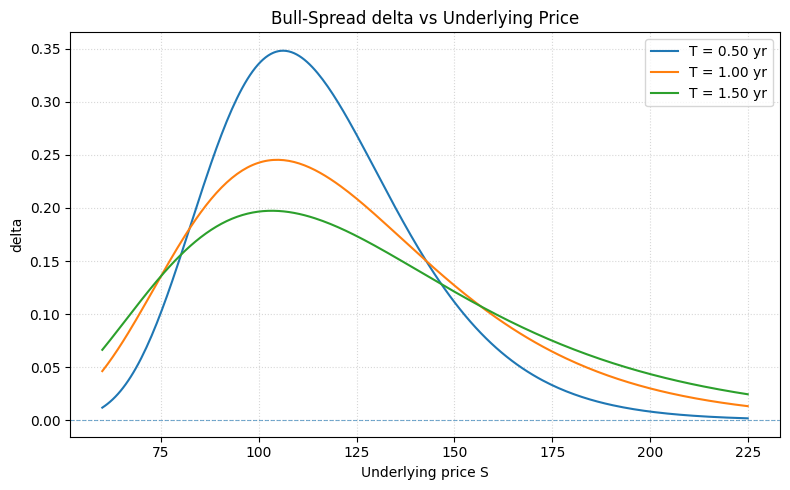

In [21]:

def bull_greek_scenarios(params, greek_you_want, show=True):
    """
    params = {
        "K": 100.0,
        "scenarios": [
            {"S": 120, "sigma": 0.33, "r": 0.04, "T": 0.5},
            {"S": 150, "sigma": 0.45, "r": 0.04, "T": 1.0},
            {"S": 130, "sigma": 0.40, "r": 0.04, "T": 1.5},
        ],
    }
    Only K and the three scenarios matter; vol inside scenarios is ignored
    because the strategy already has its own leg-specific vols.
    """
   
    K = params["K"]
    scenarios = params["scenarios"]
    if len(scenarios) != 3:
        raise ValueError("Need exactly three maturity scenarios")
 
    print("\n=== Bull-Spread Prices ===")
    for i, sc in enumerate(scenarios, 1):
        price = BullSpread_Price(sc["S"], K, sc["r"], sc["T"])
        print(f"Scenario {i}: T={sc['T']:.2f}y Price = {price:,.4f}")
 
    S_grid = np.linspace(0.5 * min(sc["S"] for sc in scenarios), 1.5 * max(sc["S"] for sc in scenarios), 250)
 
    plt.figure(figsize=(8, 5))
    for sc in scenarios:
        greeks_ = bull_spread_greek(S_grid, K, sc["r"], sc["T"], greek_you_want)
        plt.plot(S_grid, greeks_, label=f"T = {sc['T']:.2f} yr")
 
    plt.title(f"Bull-Spread {greek_you_want} vs Underlying Price")
    plt.xlabel("Underlying price S")
    plt.ylabel(f"{greek_you_want}")
    plt.axhline(0, lw=0.8, ls="--", alpha=0.6)
    plt.legend()
    plt.grid(True, ls=":", alpha=0.5)
    plt.tight_layout()
    if show:
        plt.show()
 
bull_greek_scenarios(demo_params, greek_you_want=greek_you_want, show=True)
 
 
 
 